In [1]:
# import dependencies
import yfinance as yf
import pandas as pd
from prophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go

import numpy as np
import os
import requests
import json
from dotenv import load_dotenv


## Step 1 : Retrieve Stock Data with the yFinance SDK
1. **Get the Top 3 Companies by Sector:**
    - Use the `yFinance` SDK to retrieve a list of the top 3 companies within each sector.
2. **Obtain 5 years of Historical Data.**
    - Pull historical stock data for each of these companies, covering the past 5 years to analyze performance and trends.

In [2]:
# Define the sectors to analyze
sectors = ['technology', 'healthcare', 'financial-services', 'energy', 'consumer-cyclical']
top_sector_dfs = []

for sector in sectors:

    # Retrieve the top companies in the current sector (outputs a DataFrame)
    top_companies = yf.Sector(sector).top_companies

    # Filter out records where the 'rating' column is None to avoid any issues
    # and retrieve the top 3 companies with a valid rating
    top_3_companies = top_companies[top_companies['rating'].notna()].head(3)

    # Add a 'sector' column to identify the sector for each company
    top_3_companies['sector'] = sector

    # Append the DataFrame to the list for later concatenation
    top_sector_dfs.append(top_3_companies)
    
# Combine all sector data into a single DataFrame
top_companies_df = pd.concat(top_sector_dfs, axis=0)
top_companies_df

,name,rating,market weight,sector
symbol,,,,
NVDA,NVIDIA Corporation,Buy,0.187295,technology
AAPL,Apple Inc.,Buy,0.182572,technology
MSFT,Microsoft Corporation,Buy,0.163190,technology
LLY,Eli Lilly and Company,Buy,0.107391,healthcare
UNH,UnitedHealth Group Incorporated,Buy,0.083205,healthcare
JNJ,Johnson & Johnson,Buy,0.057213,healthcare
BRK-B,Berkshire Hathaway Inc.,Buy,0.100580,financial-services
JPM,JPMorgan Chase & Co.,Buy,0.081622,financial-services
V,Visa Inc.,Buy,0.059929,financial-services


In [3]:
# Get all the symbols into a list
tickers = top_companies_df.index.to_list()
print(tickers)

['NVDA', 'AAPL', 'MSFT', 'LLY', 'UNH', 'JNJ', 'BRK-B', 'JPM', 'V', 'XOM', 'CVX', 'COP', 'AMZN', 'TSLA', 'HD']


In [4]:
# Dictionary to store historical data for each ticker
historical_data = {}

for ticker in tickers:
    
    # Initialize the ticker object
    stock = yf.Ticker(ticker)

    # Retrieve 5 years of historical market data for the current ticker
    historical_data[ticker] = stock.history(period="5y")

    # Add the ticker symbol as a column to the DataFrame
    historical_data[ticker]['Symbol'] = ticker


In [5]:
# Create a DataFrame for the historical data
historical_df = pd.concat(historical_data, axis = 0)

# Display the first 5 and last 5 rows of the DataFrame
display(historical_df.head(5))
display(historical_df.tail(5))

Open      High       Low     Close  \
     Date                                                                
NVDA 2019-11-19 00:00:00-05:00  5.250214  5.273849  5.116365  5.174582   
     2019-11-20 00:00:00-05:00  5.151693  5.337788  5.139004  5.253945   
     2019-11-21 00:00:00-05:00  5.249467  5.305196  5.207421  5.229066   
     2019-11-22 00:00:00-05:00  5.251706  5.298230  5.223095  5.246731   
     2019-11-25 00:00:00-05:00  5.374857  5.508458  5.361920  5.503482   

                                   Volume  Dividends  Stock Splits Symbol  
     Date                                                                  
NVDA 2019-11-19 00:00:00-05:00  414564000        0.0           0.0   NVDA  
     2019-11-20 00:00:00-05:00  472588000        0.0           0.0   NVDA  
     2019-11-21 00:00:00-05:00  288388000        0.0           0.0   NVDA  
     2019-11-22 00:00:00-05:00  224100000        0.0           0.0   NVDA  
     2019-11-25 00:00:00-05:00  506476000        0.0           0.0   NVDA

Open        High         Low       Close  \
   Date                                                                        
HD 2024-11-13 00:00:00-05:00  409.130005  412.739990  406.720001  410.190002   
   2024-11-14 00:00:00-05:00  408.000000  411.500000  404.390015  405.720001   
   2024-11-15 00:00:00-05:00  402.899994  408.910004  402.899994  408.179993   
   2024-11-18 00:00:00-05:00  405.500000  412.540009  403.950012  410.440002   
   2024-11-19 00:00:00-05:00  408.380005  409.160004  399.359985  407.999786   

                               Volume  Dividends  Stock Splits Symbol  
   Date                                                                
HD 2024-11-13 00:00:00-05:00  3083100        0.0           0.0     HD  
   2024-11-14 00:00:00-05:00  3348100        0.0           0.0     HD  
   2024-11-15 00:00:00-05:00  3239500        0.0           0.0     HD  
   2024-11-18 00:00:00-05:00  3394300        0.0           0.0     HD  
   2024-11-19 00:00:00-05:00  1459065        0.0           0.0     HD

In [8]:
# The dataframe has multiple indices.  So, we need to drop the first and just keep the Date as index
historical_df = historical_df.reset_index(level=0, drop=True)

# Convert the index to datetime
historical_df.index = pd.to_datetime(historical_df.index)

# Remove the timestamp and keep only the date part
historical_df.index = historical_df.index.date

# Display the DataFrame to check
display(historical_df.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-19,5.250214,5.273849,5.116365,5.174582,414564000,0.0,0.0,NVDA
2019-11-20,5.151693,5.337788,5.139004,5.253945,472588000,0.0,0.0,NVDA
2019-11-21,5.249467,5.305196,5.207421,5.229066,288388000,0.0,0.0,NVDA
2019-11-22,5.251706,5.298230,5.223095,5.246731,224100000,0.0,0.0,NVDA
2019-11-25,5.374857,5.508458,5.361920,5.503482,506476000,0.0,0.0,NVDA


## Step 2 : Create visuals to determine interesting patters within these stocks

1. A regular (linear scale) graph to observe absolute price growth.
2. A logarithmic scale graph to focus on relative (percentage-based) growth.

- **Regular Scale Graph:** Highlights the absolute stock price increases over time. This graph is particularly useful for identifying which stock has the highest dollar-value growth.

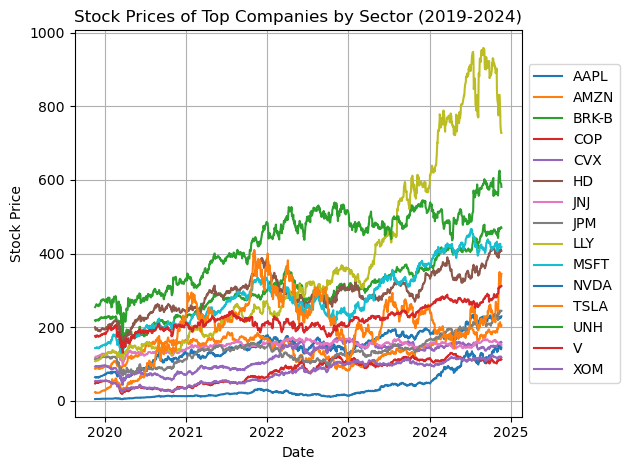

In [13]:
# plot the visualization for the stock price

historical_df.groupby('Symbol')['Close'].plot()

# Add the legend to the visual
plt.legend(title = 'Ticker')

plt.title("Stock Prices of Top Companies by Sector (2019-2024)")
plt.grid(True)

# Add the axis labels
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Adjust legend placement
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the graph with the added features
plt.tight_layout()
plt.show()

- **Logarithmic Scale Graph:** Emphasizes the relative (percentage) growth of each stock, making it easier to compare growth rates.

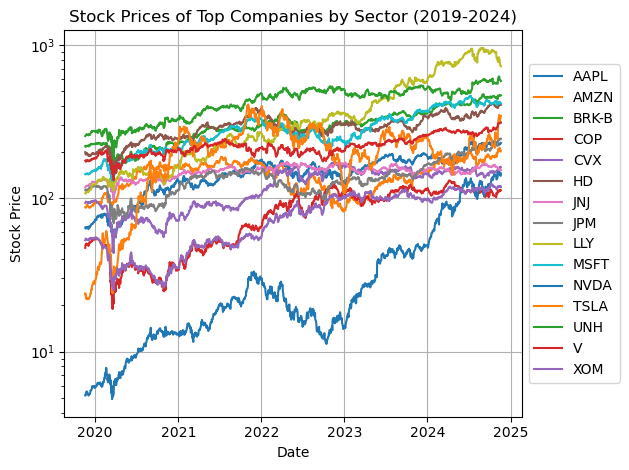

In [14]:
# plot the visualization for the stock price

historical_df.groupby('Symbol')['Close'].plot()

# Log scale on y-axis
plt.yscale('log')

# Add the legend to the visual
plt.legend(title = 'Ticker')

plt.title("Stock Prices of Top Companies by Sector (2019-2024)")
plt.grid(True)

# Add the axis labels
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Adjust legend placement
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the graph with the added features
plt.tight_layout()
plt.show()

**Question:** What pattern looks more interesting?

**LLY (Eli Lilly)** and **NVDA (NVIDIA)** seem to be the interesting candidates for further analysis with financial data, as they both exhibit standout patterns that suggest potential insights:
- **LLY (Eli Lilly)** shows the most notable absolute price increase, suggesting strong performance in dollar terms. 
- **NVDA (NVIDIA)** has experienced the highest relative growth over the period, which is interesting because it indicates a dramatic percentage increase from its initial value.


In [15]:
# Filter the DataFrame to keep only rows with 'Symbol' as 'NVDA' or 'LLY'
historical_df= historical_df.loc[historical_df['Symbol'].isin(['NVDA', 'LLY'])]

# Display the first and last 5 records to verify the slice
display(historical_df.head())
display(historical_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-19,5.250214,5.273849,5.116365,5.174582,414564000,0.0,0.0,NVDA
2019-11-20,5.151693,5.337788,5.139004,5.253945,472588000,0.0,0.0,NVDA
2019-11-21,5.249467,5.305196,5.207421,5.229066,288388000,0.0,0.0,NVDA
2019-11-22,5.251706,5.298230,5.223095,5.246731,224100000,0.0,0.0,NVDA
2019-11-25,5.374857,5.508458,5.361920,5.503482,506476000,0.0,0.0,NVDA


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2024-11-13,818.963651,827.739096,809.948553,810.467712,3059300,0.0,0.0,LLY
2024-11-14,807.852052,807.852052,782.214519,784.929993,3998800,0.0,0.0,LLY
2024-11-15,775.190002,777.979980,744.200012,746.200012,7334600,1.3,0.0,LLY
2024-11-18,733.190002,734.000000,711.400024,727.200012,9148100,0.0,0.0,LLY
2024-11-19,716.309998,728.359985,712.419983,727.690002,3657497,0.0,0.0,LLY


In [16]:
df_LLY = historical_df.loc[historical_df['Symbol'] == 'LLY']
df_NVDA = historical_df.loc[historical_df['Symbol'] == 'NVDA']

display(df_LLY.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-19,106.876051,108.834933,106.613618,107.878922,3781600,0.0,0.0,LLY
2019-11-20,107.747711,108.647482,106.894805,107.419670,3638200,0.0,0.0,LLY
2019-11-21,107.504030,108.272585,106.182493,107.550896,2909500,0.0,0.0,LLY
2019-11-22,107.869565,109.359817,107.513408,108.909927,3120100,0.0,0.0,LLY
2019-11-25,109.284822,111.028131,109.284822,110.100243,2939300,0.0,0.0,LLY


---

## Step 3: Predictions Using Prophet


### Forecasting **LLY (Eli Lilly)** Future Trends

In [18]:
df_LLY_Trends = df_LLY['Close'].reset_index()

df_LLY_Trends.rename(columns={'index': 'ds', 'Close': 'y'}, inplace=True)

display(df_LLY_Trends.head())
display(df_LLY_Trends.tail())

,ds,y
0,2019-11-19,107.878922
1,2019-11-20,107.419670
2,2019-11-21,107.550896
3,2019-11-22,108.909927
4,2019-11-25,110.100243


,ds,y
1254,2024-11-13,810.467712
1255,2024-11-14,784.929993
1256,2024-11-15,746.200012
1257,2024-11-18,727.200012
1258,2024-11-19,727.690002


In [19]:
# Initializing a new Prophet model
model_LLY_trends = Prophet()

In [21]:
# Training (Fitting) the model on the dataset df_LLY_Trends
model_LLY_trends.fit(df_LLY_Trends)

14:12:21 - cmdstanpy - INFO - Chain [1] start processing
14:12:22 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Create a dataframe to hold future predictions
# Make the prediction for the next year (365 days)
future_LLY_trends = model_LLY_trends.make_future_dataframe(periods=365 , freq='D')

# View the last five rows of the future_mercado_trends DataFrame
future_LLY_trends.tail()

,ds
1619,2025-11-15
1620,2025-11-16
1621,2025-11-17
1622,2025-11-18
1623,2025-11-19


In [23]:
# Make the predictions for the trend data
forecast_LLY_trends = model_LLY_trends.predict(future_LLY_trends)

# Display the first five rows of the forecast_LLY_trends DataFrame
forecast_LLY_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-19,125.834543,67.706482,135.204407,125.834543,125.834543,-24.440678,-24.440678,-24.440678,3.457527,3.457527,3.457527,-27.898206,-27.898206,-27.898206,0.0,0.0,0.0,101.393865
1,2019-11-20,125.872034,66.364440,137.153034,125.872034,125.872034,-22.494148,-22.494148,-22.494148,4.194817,4.194817,4.194817,-26.688965,-26.688965,-26.688965,0.0,0.0,0.0,103.377886
2,2019-11-21,125.909525,69.399995,139.419961,125.909525,125.909525,-21.924002,-21.924002,-21.924002,3.483481,3.483481,3.483481,-25.407483,-25.407483,-25.407483,0.0,0.0,0.0,103.985523
3,2019-11-22,125.947016,69.817157,137.700907,125.947016,125.947016,-20.388054,-20.388054,-20.388054,3.690758,3.690758,3.690758,-24.078812,-24.078812,-24.078812,0.0,0.0,0.0,105.558962
4,2019-11-25,126.059488,74.665393,142.886294,126.059488,126.059488,-16.466943,-16.466943,-16.466943,3.594392,3.594392,3.594392,-20.061334,-20.061334,-20.061334,0.0,0.0,0.0,109.592545


In [24]:
# Create a Plotly figure
fig = go.Figure()

# Add the forecasted trend line
fig.add_trace(go.Scatter(
    x=forecast_LLY_trends['ds'],
    y=forecast_LLY_trends['yhat'],
    mode='lines',
    name='Forecasted Trend',
    hovertemplate='Date: %{x}<br>Forecast: %{y:.2f}'
))

# Add the actual data points (if you want to compare them)
fig.add_trace(go.Scatter(
    x=df_LLY_Trends['ds'],
    y=df_LLY_Trends['y'],
    mode='markers',
    name='Actual Data',
    hovertemplate='Date: %{x}<br>Actual: %{y:.2f}'
))

# Add upper and lower forecast boundaries as filled areas
fig.add_trace(go.Scatter(
    x=forecast_LLY_trends['ds'],
    y=forecast_LLY_trends['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast_LLY_trends['ds'],
    y=forecast_LLY_trends['yhat_lower'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0, 100, 80, 0.2)',
    name='Confidence Interval',
    hoverinfo='skip'
))

# Customize layout
fig.update_layout(
    title="LLY Forecasted Trend with Prophet",
    xaxis_title="Date",
    yaxis_title="Forecasted Stock Price (Close)",
    hovermode="x unified"
)

# Show the interactive plot
fig.show()


**Analysis:** Based on the plot, it appears that the forecasted trend for LLY (Eli Lilly) shows a continued upward movement, suggesting a positive growth outlook for the stock over the next year.

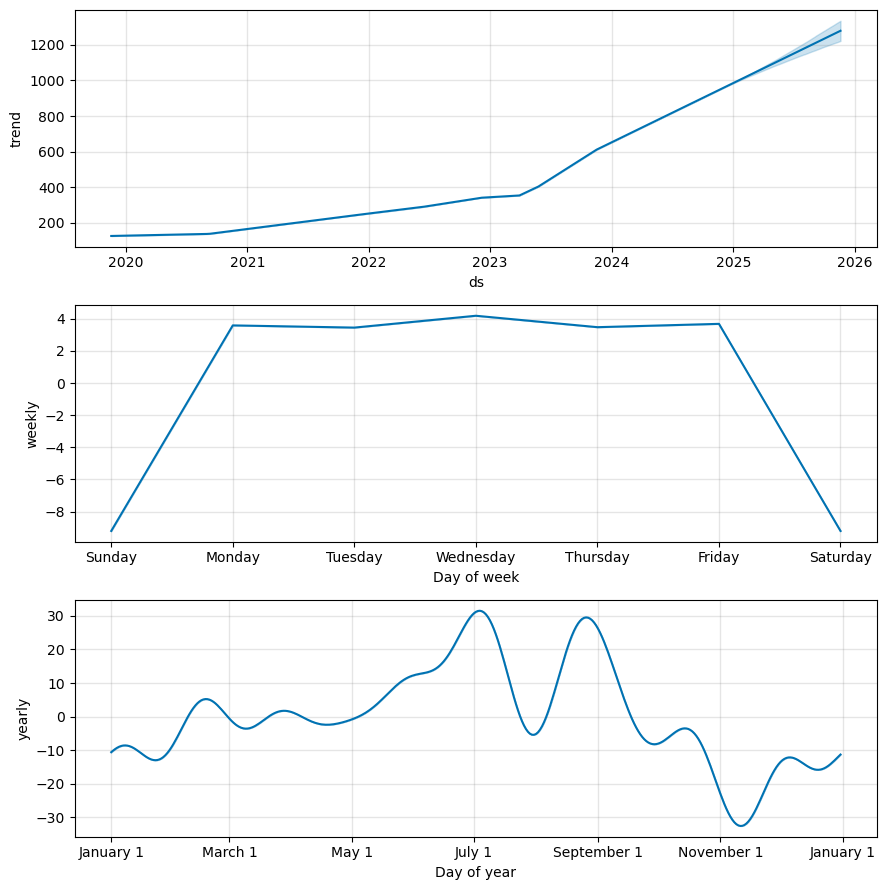

In [25]:
# Plot the yearly seasonality component
figs = model_LLY_trends.plot_components(forecast_LLY_trends)

The yearly trend shows that stock prices generally increase from around May to July, then experience a sharp decline in July. There is a recovery in August, with another rise into September, followed by a steady decline through November.  To further understand this analysis we can look into the data within this period. 

### Forecasting **NVDA (NVIDIA)** Future Trends

In [26]:
df_NVDA_Trends = df_NVDA['Close'].reset_index()

df_NVDA_Trends.rename(columns={'index': 'ds', 'Close': 'y'}, inplace=True)

display(df_NVDA_Trends.head())
display(df_NVDA_Trends.tail())

,ds,y
0,2019-11-19,5.174582
1,2019-11-20,5.253945
2,2019-11-21,5.229066
3,2019-11-22,5.246731
4,2019-11-25,5.503482


,ds,y
1254,2024-11-13,146.270004
1255,2024-11-14,146.759995
1256,2024-11-15,141.979996
1257,2024-11-18,140.149994
1258,2024-11-19,145.349899


In [27]:
# Initializing a new Prophet model
model_NVDA_trends = Prophet()

In [28]:
model_NVDA_trends.fit(df_NVDA_Trends)

14:15:49 - cmdstanpy - INFO - Chain [1] start processing
14:15:49 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future_NVDA_trends = model_NVDA_trends.make_future_dataframe(periods=365, freq='D')

# View the last five rows of the future_mercado_trends DataFrame
future_NVDA_trends.tail()

,ds
1619,2025-11-15
1620,2025-11-16
1621,2025-11-17
1622,2025-11-18
1623,2025-11-19


In [30]:
# Make the predictions for the trend data
forecast_NVDA_trends = model_NVDA_trends.predict(future_NVDA_trends)

# Display the first five rows of the forecast_LLY_trends DataFrame
forecast_NVDA_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-19,7.049066,2.101367,12.640731,7.049066,7.049066,0.215255,0.215255,0.215255,0.400962,0.400962,0.400962,-0.185707,-0.185707,-0.185707,0.0,0.0,0.0,7.264321
1,2019-11-20,7.046150,1.920212,12.489109,7.046150,7.046150,0.005202,0.005202,0.005202,0.274885,0.274885,0.274885,-0.269683,-0.269683,-0.269683,0.0,0.0,0.0,7.051352
2,2019-11-21,7.043234,1.942648,12.332613,7.043234,7.043234,0.043916,0.043916,0.043916,0.409046,0.409046,0.409046,-0.365129,-0.365129,-0.365129,0.0,0.0,0.0,7.087150
3,2019-11-22,7.040318,1.292765,12.482747,7.040318,7.040318,-0.106886,-0.106886,-0.106886,0.363520,0.363520,0.363520,-0.470405,-0.470405,-0.470405,0.0,0.0,0.0,6.933433
4,2019-11-25,7.031570,1.605730,11.775167,7.031570,7.031570,-0.364322,-0.364322,-0.364322,0.464187,0.464187,0.464187,-0.828509,-0.828509,-0.828509,0.0,0.0,0.0,6.667249


In [31]:
# Create a Plotly figure
fig = go.Figure()

# Add the forecasted trend line
fig.add_trace(go.Scatter(
    x=forecast_NVDA_trends['ds'],
    y=forecast_NVDA_trends['yhat'],
    mode='lines',
    name='Forecasted Trend',
    hovertemplate='Date: %{x}<br>Forecast: %{y:.2f}'
))

# Add the actual data points (if you want to compare them)
fig.add_trace(go.Scatter(
    x=df_NVDA_Trends['ds'],
    y=df_NVDA_Trends['y'],
    mode='markers',
    name='Actual Data',
    hovertemplate='Date: %{x}<br>Actual: %{y:.2f}'
))

# Add upper and lower forecast boundaries as filled areas
fig.add_trace(go.Scatter(
    x=forecast_NVDA_trends['ds'],
    y=forecast_NVDA_trends['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast_NVDA_trends['ds'],
    y=forecast_NVDA_trends['yhat_lower'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0, 100, 80, 0.2)',
    name='Confidence Interval',
    hoverinfo='skip'
))

# Customize layout
fig.update_layout(
    title="NVDA Forecasted Trend with Prophet",
    xaxis_title="Date",
    yaxis_title="Forecasted Stock Price (Close)",
    hovermode="x unified"
)

# Show the interactive plot
fig.show()


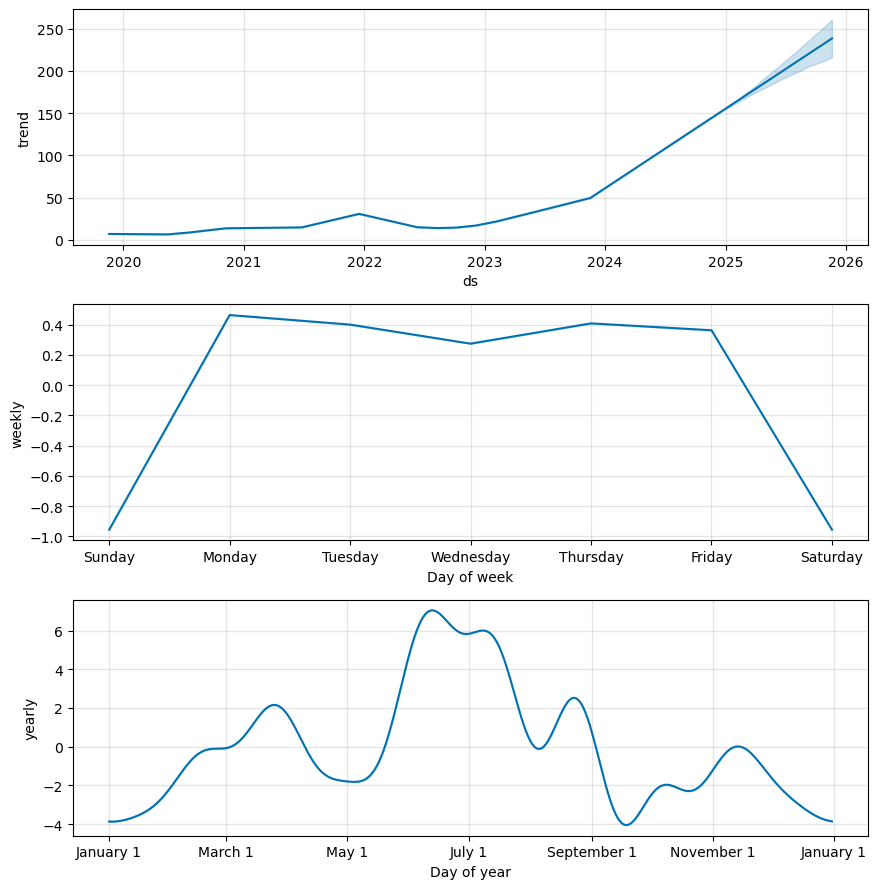

In [32]:
# Plot the yearly seasonality component
figs = model_NVDA_trends.plot_components(forecast_NVDA_trends)

---

## Step 4:  Retrieve Financial Data with the Alpha Vantage API

1. **Get Income Statement and Cash Flow Data:**
    - Use the Alpha Vantage API to retrieve financial data for each company, including the Income Statement and Cash Flow reports.
    - Focus on key metrics such as `Total Revenue` and `Free Cash Flow` to assess financial health.

2. **Calculate Net Profit Margin:**
    - From the Income Statement, use `Net Profit` and `Total Revenue` to calculate the **Net Profit Margin** for each company, which helps measure profitability.

In [33]:
# Load environment variables from the .env file
load_dotenv()

# Access the ALPHA_API_KEY
alpha_api_key = os.getenv("ALPHA_API_KEY")


In [34]:
# List of tickers selected for further analysis
selected_tickers = ['LLY', 'NVDA']

### Retrieve Income Statements Data

In [35]:
# Initialize an empty list to store quarterly income statements for each ticker
alpha_quarterly_income_statements = []

# Loop through each ticker in the selected tickers list
for ticker in selected_tickers:
    
    # Construct the API URL to fetch the income statement data for the current ticker
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={alpha_api_key}"
    
    # Send a GET request to the API and retrieve the response in JSON format
    response = requests.get(url).json()
    
    # Loop through each quarterly report in the response (if available)
    for report in response.get("quarterlyReports", []):
        # Add the ticker symbol to each report to identify the data's source
        report["symbol"] = ticker

    # Append the list of quarterly reports to the main list (or an empty list if no reports are available)
    alpha_quarterly_income_statements.append(response.get("quarterlyReports", []))

In [36]:
# Initialize an empty list to store the extracted data
income_statements_data= []

# Loop through each quarterly report in the ticker's income statements
for ticker in alpha_quarterly_income_statements:

    for _ in ticker: 
        
         # Create a dictionary for the extracted fields
        record = {
            'Date': pd.to_datetime(_['fiscalDateEnding']), 
            'Symbol': _['symbol'], 
            'Gross Profit': int(_['grossProfit']), 
            'Total Revenue': int(_['totalRevenue'])
        }
        
        # Append the dictionary to the data list
        income_statements_data.append(record)

In [37]:
# Create a DataFrame from the data and set 'Date' as the index
income_statements_df = pd.DataFrame(income_statements_data).set_index('Date')

# Show the first and last 5 records
display(income_statements_df.head())
display(income_statements_df.tail())

,Symbol,Gross Profit,Total Revenue
Date,,,
2024-09-30,LLY,7202300000,11439100000
2024-06-30,LLY,6694700000,11302800000
2024-03-31,LLY,5258400000,8768000000
2023-12-31,LLY,5182500000,9353400000
2023-09-30,LLY,5950100000,9498600000


,Symbol,Gross Profit,Total Revenue
Date,,,
2009-07-26,NVDA,156723000,776520000
2009-04-26,NVDA,189696000,664231000
2009-01-25,NVDA,141666000,481140000
2008-10-26,NVDA,367843000,897655000
2008-07-27,NVDA,149917000,892676000


### Retrieve Cashflow data

In [38]:
# Initialize an empty list to store quarterly CashFlow for each ticker
alpha_quarterly_cashflow = []

# Loop through each ticker in the selected tickers list
for ticker in selected_tickers:
    
    # Construct the API URL to fetch the Cash Flow data for the current ticker
    casflow_url = f"https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={alpha_api_key}"
    
    # Send a GET request to the API and retrieve the response in JSON format
    response = requests.get(casflow_url).json()
    
    # Loop through each quarterly report in the response (if available)
    for _ in response.get("quarterlyReports", []):
        # Add the ticker symbol to each report to identify the data's source
        _["symbol"] = ticker

    # Append the list of quarterly reports to the main list (or an empty list if no reports are available)
    alpha_quarterly_cashflow.append(response.get("quarterlyReports", []))

In [39]:
# Initialize an empty list to store the extracted data
cashflow_data= []

# Loop through each quarterly report in the ticker's income statements
for ticker in alpha_quarterly_cashflow:

    for _ in ticker: 
        
         # Create a dictionary for the extracted fields
        record = {
            'Date': pd.to_datetime(_['fiscalDateEnding']), 
            'Symbol': _['symbol'], 
            'Operating Cashflow': int(_['operatingCashflow']), 
            'Capital Expenditures': int(_['capitalExpenditures']),
            'Net Income': int(_['netIncome'])
        }
        
        # Append the dictionary to the data list
        cashflow_data.append(record)

In [40]:
# Create a DataFrame from the data and set 'Date' as the index
cashflow_df = pd.DataFrame(cashflow_data).set_index('Date')

# Show the first and last 5 records
display(cashflow_df.head())
display(cashflow_df.tail())

,Symbol,Operating Cashflow,Capital Expenditures,Net Income
Date,,,,
2024-09-30,LLY,3711900000,1350700000,970300000
2024-06-30,LLY,1466200000,1224800000,2967000000
2024-03-31,LLY,1166000000,986300000,2242900000
2023-12-31,LLY,-311900000,1070600000,2189700000
2023-09-30,LLY,2189500000,970300000,-57400000


,Symbol,Operating Cashflow,Capital Expenditures,Net Income
Date,,,,
2010-10-31,NVDA,212177000,21823000,84862000
2010-08-01,NVDA,34344000,37644000,-140961000
2010-05-02,NVDA,-5397000,17080000,137594000
2010-01-31,NVDA,69245000,22575000,131076000
2009-10-25,NVDA,141317000,16593000,107577000


In [41]:
# Calculate Free Cash Flow and add it as a new column
cashflow_df['Free Cash Flow (FCF)'] = cashflow_df['Operating Cashflow'] - cashflow_df['Capital Expenditures']

# Display the first few rows to verify the new column
cashflow_df.head()

,Symbol,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF)
Date,,,,,
2024-09-30,LLY,3711900000,1350700000,970300000,2361200000
2024-06-30,LLY,1466200000,1224800000,2967000000,241400000
2024-03-31,LLY,1166000000,986300000,2242900000,179700000
2023-12-31,LLY,-311900000,1070600000,2189700000,-1382500000
2023-09-30,LLY,2189500000,970300000,-57400000,1219200000


## Merge the datasets

In [ ]:
# Merge the income statements data with cashflow data on 'Date' and 'Symbol'
company_finance_df = pd.merge(income_statements_df, cashflow_df, on=["Date", "Symbol"])

# Display the result
display(company_finance_df.head())

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF)
Date,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000


In [43]:
# Calculate 'Net Profit Margin' and add it as a new column
company_finance_df['Net Profit Margin (%)'] = (company_finance_df['Net Income'] / company_finance_df['Total Revenue']) * 100

# Calculate 'Return of Investment (ROI) and add it as a new column
company_finance_df['Return of Investment (ROI)'] = ((company_finance_df['Net Income'] - company_finance_df['Capital Expenditures']) / company_finance_df['Capital Expenditures']) * 100

# Display the first few rows to verify the new column
company_finance_df.head()

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%),Return of Investment (ROI)
Date,,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311,-28.163175
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133,142.243632
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520,127.405455
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738,104.530170
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300,-105.915696


In [56]:
# Filter the dataframe to include only the data from 2019 onwards
# Use .copy() to avoid modifiying the original Dataframe (company_finance_df); otherwise it will create "view" on the original dataframe

filtered_finance_df = company_finance_df[company_finance_df.index >= '2019'].copy()

# Verify the filtered data by inspecting the indices
filtered_finance_df.index

DatetimeIndex(['2024-09-30', '2024-06-30', '2024-03-31', '2023-12-31',
               '2023-09-30', '2023-06-30', '2023-03-31', '2022-12-31',
               '2022-09-30', '2022-06-30', '2022-03-31', '2021-12-31',
               '2021-09-30', '2021-06-30', '2021-03-31', '2020-12-31',
               '2020-09-30', '2020-06-30', '2020-03-31', '2019-12-31',
               '2019-09-30', '2019-06-30', '2019-03-31', '2024-07-28',
               '2024-04-28', '2024-01-28', '2023-10-29', '2023-07-30',
               '2023-04-30', '2023-01-29', '2022-10-30', '2022-07-31',
               '2022-05-01', '2022-01-30', '2021-10-31', '2021-08-01',
               '2021-05-02', '2021-01-31', '2020-10-25', '2020-07-26',
               '2020-04-26', '2020-01-26', '2019-10-27', '2019-07-28',
               '2019-04-28', '2019-01-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

---

## Visualizations for Company Financials
This section provides bar charts for visualizing key financial metrics:

- **Free Cash Flow (FCF)**: Illustrates the cash generated after accounting for operating expenses and capital expenditures, providing insights into the company's liquidity.

- **Net Profit Margin**: Depicts the percentage of revenue that remains as profit after all expenses, highlighting profitability.

- **Return on Investment (ROI)**: Represents the efficiency of investments in generating returns, offering a clear picture of overall performance.

In [61]:
df_LLY = filtered_finance_df[filtered_finance_df['Symbol'] == 'LLY']
df_NVDA = filtered_finance_df[filtered_finance_df['Symbol'] == 'NVDA']

In [67]:
filtered_finance_df['Quarter'] = filtered_finance_df.index.to_period('Q')
filtered_finance_df.head()

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%),Return of Investment (ROI),Quarter
Date,,,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311,-28.163175,2024Q3
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133,142.243632,2024Q2
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520,127.405455,2024Q1
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738,104.530170,2023Q4
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300,-105.915696,2023Q3


In [68]:
filtered_finance_df['Quarter'] = filtered_finance_df['Quarter'].astype(str).str[-2:]
filtered_finance_df.head()

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%),Return of Investment (ROI),Quarter
Date,,,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311,-28.163175,Q3
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133,142.243632,Q2
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520,127.405455,Q1
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738,104.530170,Q4
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300,-105.915696,Q3


In [70]:
# Ensure Quarter is in string format and combine it with the year
filtered_finance_df['Year_Quarter'] = filtered_finance_df.index.to_period('Q').astype(str)

### Free Cash Flow Graph

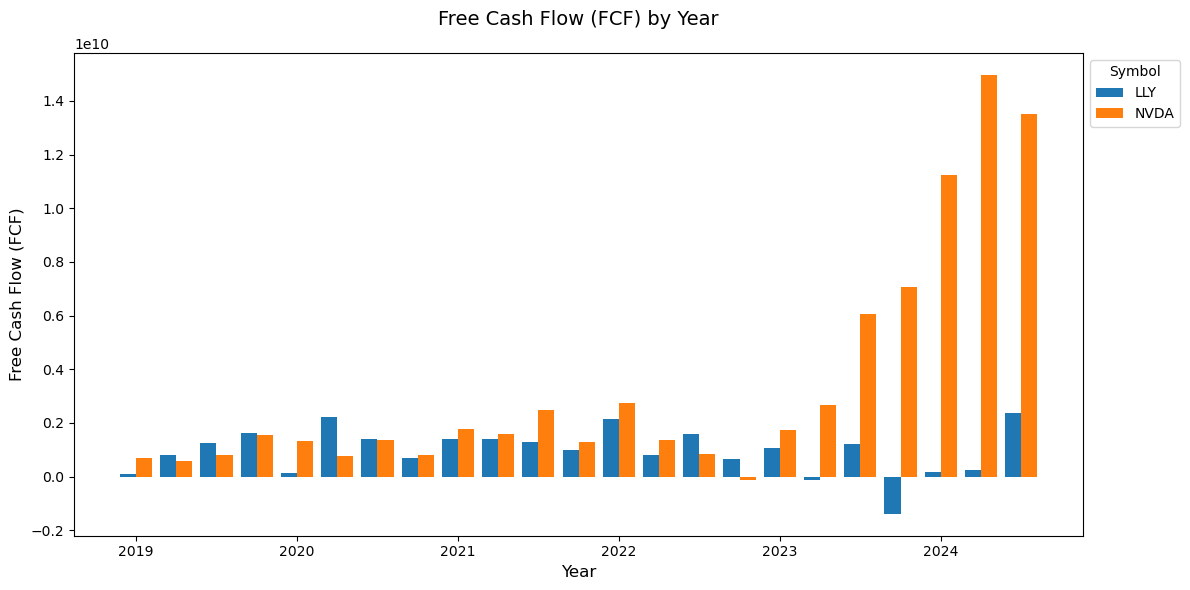

In [73]:


# Group data by Symbol and Year_Quarter
grouped_data = filtered_finance_df.groupby(['Year_Quarter', 'Symbol'])['Free Cash Flow (FCF)'].sum().unstack()

# Sample grouped data (replace with your `grouped_data`)
# Ensure the data has a MultiIndex with Year and Quarter levels
grouped_data.index = pd.MultiIndex.from_tuples(
    [(x[:4], x[4:]) for x in grouped_data.index],
    names=["Year", "Quarter"]
)

# Generate x positions for the bars
x = np.arange(len(grouped_data))  # Numeric positions for each quarter
width = 0.4  # Bar width

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each company
bar1 = ax.bar(x - width / 2, grouped_data['LLY'], width, label='LLY', color='#1f77b4')
bar2 = ax.bar(x + width / 2, grouped_data['NVDA'], width, label='NVDA', color='#ff7f0e')

# Customize the x-axis ticks to only show years
years = grouped_data.index.get_level_values("Year").unique()
year_positions = [i for i, year in enumerate(grouped_data.index.get_level_values("Year")) if i == 0 or year != grouped_data.index.get_level_values("Year")[i - 1]]
ax.set_xticks(year_positions)
ax.set_xticklabels(years)

# Add labels, title, and legend
ax.set_title("Free Cash Flow (FCF) by Year", fontsize=14, pad=20)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Free Cash Flow (FCF)", fontsize=12)
ax.legend(title="Symbol", loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()


### Net Profit Margin Graph

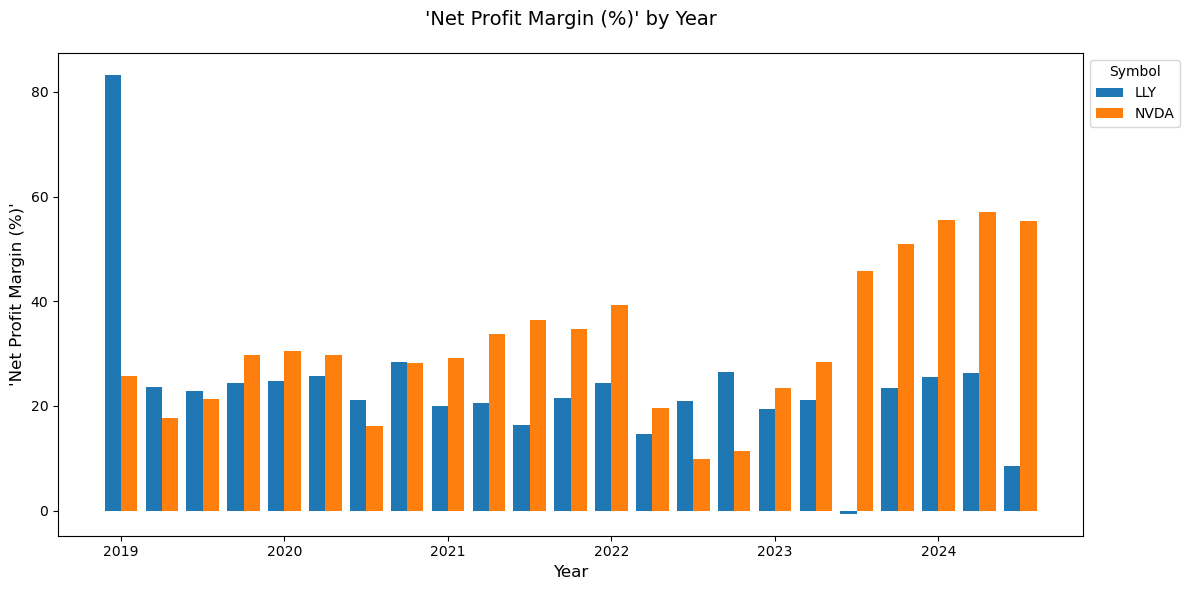

In [ ]:
# Group data by Symbol and Year_Quarter
grouped_data = filtered_finance_df.groupby(['Year_Quarter', 'Symbol'])['Net Profit Margin (%)'].sum().unstack()

# Sample grouped data (replace with your `grouped_data`)
# Ensure the data has a MultiIndex with Year and Quarter levels
grouped_data.index = pd.MultiIndex.from_tuples(
    [(x[:4], x[4:]) for x in grouped_data.index],
    names=["Year", "Quarter"]
)

# Generate x positions for the bars
x = np.arange(len(grouped_data))  # Numeric positions for each quarter
width = 0.4  # Bar width

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each company
bar1 = ax.bar(x - width / 2, grouped_data['LLY'], width, label='LLY', color='#1f77b4')
bar2 = ax.bar(x + width / 2, grouped_data['NVDA'], width, label='NVDA', color='#ff7f0e')

# Customize the x-axis ticks to only show years
years = grouped_data.index.get_level_values("Year").unique()
year_positions = [i for i, year in enumerate(grouped_data.index.get_level_values("Year")) if i == 0 or year != grouped_data.index.get_level_values("Year")[i - 1]]
ax.set_xticks(year_positions)
ax.set_xticklabels(years)

# Add labels, title, and legend
ax.set_title("Net Profit Margin (%) by Year", fontsize=14, pad=20)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("'Net Profit Margin (%)'", fontsize=12)
ax.legend(title="Symbol", loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()


### Return of Investment Graph

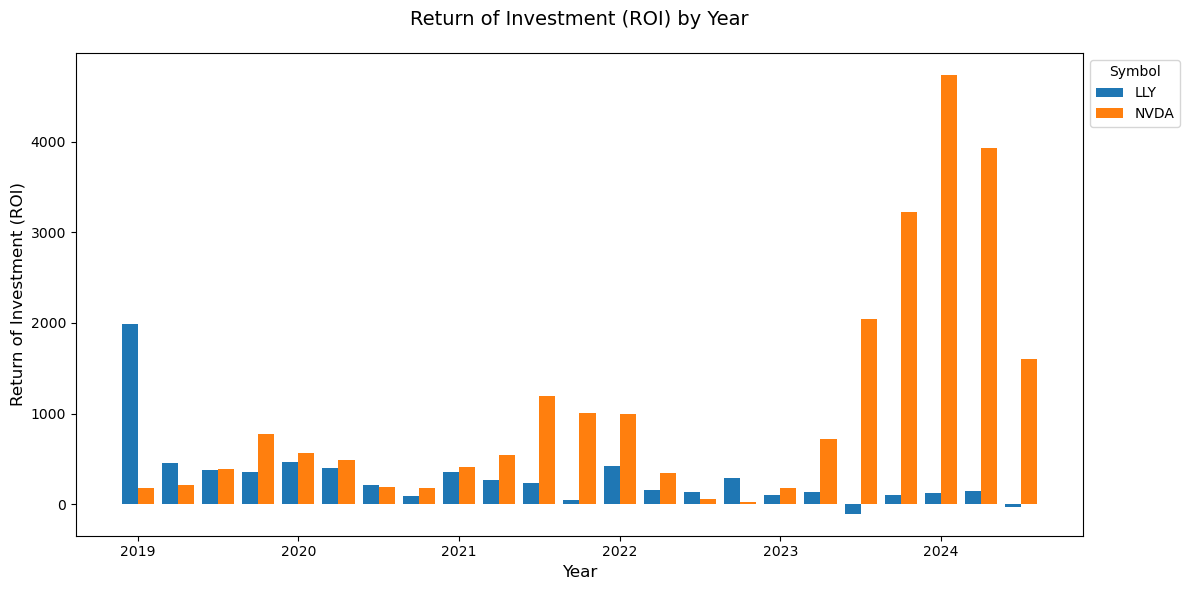

In [75]:
# Group data by Symbol and Year_Quarter
grouped_data = filtered_finance_df.groupby(['Year_Quarter', 'Symbol'])['Return of Investment (ROI)'].sum().unstack()

# Sample grouped data (replace with your `grouped_data`)
# Ensure the data has a MultiIndex with Year and Quarter levels
grouped_data.index = pd.MultiIndex.from_tuples(
    [(x[:4], x[4:]) for x in grouped_data.index],
    names=["Year", "Quarter"]
)

# Generate x positions for the bars
x = np.arange(len(grouped_data))  # Numeric positions for each quarter
width = 0.4  # Bar width

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each company
bar1 = ax.bar(x - width / 2, grouped_data['LLY'], width, label='LLY', color='#1f77b4')
bar2 = ax.bar(x + width / 2, grouped_data['NVDA'], width, label='NVDA', color='#ff7f0e')

# Customize the x-axis ticks to only show years
years = grouped_data.index.get_level_values("Year").unique()
year_positions = [i for i, year in enumerate(grouped_data.index.get_level_values("Year")) if i == 0 or year != grouped_data.index.get_level_values("Year")[i - 1]]
ax.set_xticks(year_positions)
ax.set_xticklabels(years)

# Add labels, title, and legend
ax.set_title("Return of Investment (ROI) by Year", fontsize=14, pad=20)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel('Return of Investment (ROI)', fontsize=12)
ax.legend(title="Symbol", loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()


---